In [ ]:
!pip install pmdarima

# Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import seaborn as sns

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from sklearn.linear_model import LinearRegression as lm
import statsmodels.api as sm

Defining the functions

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return (diff)

In [ ]:
def runMyAR1(yin):
    tlen = len(yin)
    y = np.array(yin[2:tlen])
    x = np.array(yin[1:(tlen-1)])
    X = x
    X = sm.add_constant(X)
    regr2 = sm.OLS(y,X)
    model = regr2.fit()
    print(model.summary())
    ypred = model.predict()
    plt.plot((y-ypred))

In [ ]:
# Create large images!
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(14, 8)) # was 16,12
plt.rc("font", size=13)

Importing Data

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/DS Aegis/Time Series Adv Stats/All 3 models on datasets/Brent Spot Price.csv')

In [ ]:
df.head()

,Unnamed: 0,"Brent crude oil spot price, Monthly (dollars per barrel)"
0,1990 01,21.251
1,1990 02,19.813
2,1990 03,18.387
3,1990 04,16.612
4,1990 05,16.352


In [ ]:
df.rename(columns={'Unnamed: 0':'Year-Month','Brent crude oil spot price, Monthly (dollars per barrel)':'Price'}, inplace=True)
df.head()

,Year-Month,Price
0,1990 01,21.251
1,1990 02,19.813
2,1990 03,18.387
3,1990 04,16.612
4,1990 05,16.352


lets see the original dataset then we will split into train and test

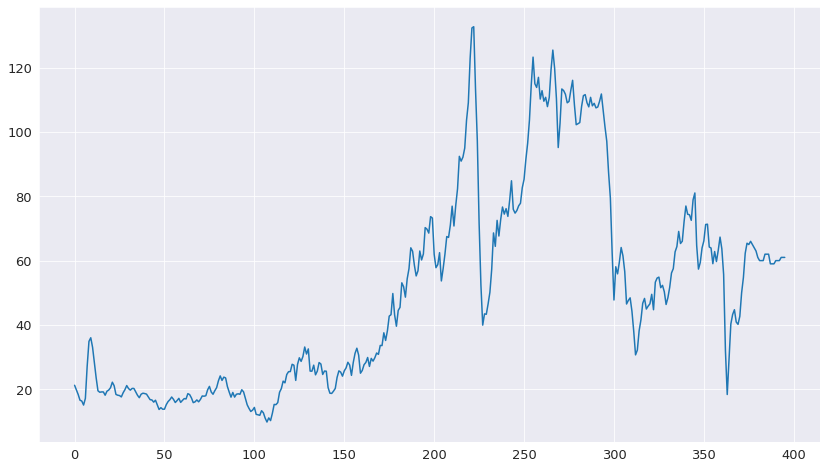

In [ ]:
plt.plot(df['Price'])

----------------------------------------------------------------------------
- We can see mix trend in the dataset but its increasing for sure
- Variance is also significant
- Seasonality is not so visible but lets decide it after decomposition
----------------------------------------------------------------------------

Splitting the dataset into train and test

In [ ]:
df.shape

(396, 2)

In [ ]:
df=df['Price']

In [ ]:
n=int(df.shape[0]*0.7) #test size=30% data
train=df.iloc[:n]
test=df.iloc[n:]


In [ ]:
train.shape

(277,)

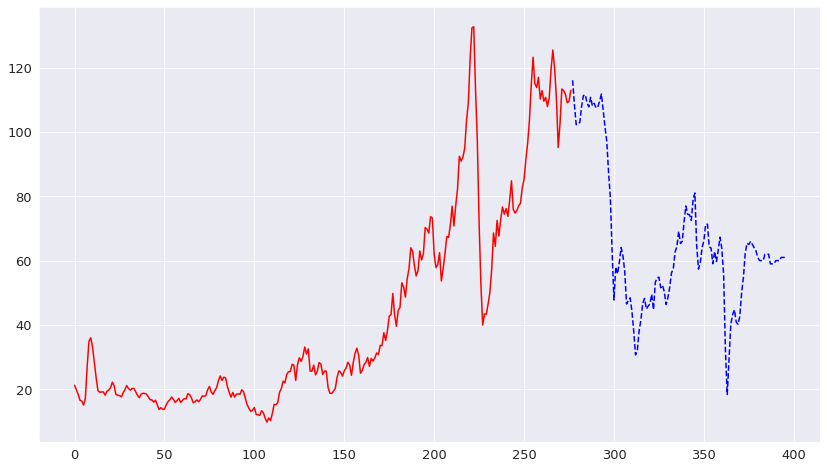

In [ ]:
plt.plot(train,'r')
plt.plot(test,'b--')

Lets perform ADF test of stationarity on the train data

**Adfuller**


- **Null hypothesis**: Non Stationarity exists in the series.

- **Alternative Hypothesis**: Stationarity exists in the series

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def dicky_fuller_test(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [ ]:
dicky_fuller_test(df)

ADF Statistic: -2.366208
p-value: 0.151502
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
Fail to reject the null hypothesis (H0), the data is non-stationary


In [ ]:
dicky_fuller_test(train)

ADF Statistic: 0.249660
p-value: 0.974913
Critical Values:
	1%: -3.455
	5%: -2.873
	10%: -2.573
Fail to reject the null hypothesis (H0), the data is non-stationary


- We can conclude that the data is non stationary as p- value is significantly greater than 0.05. 
- It means our initial observation was corrent that the data has varing mean and variance with time 

In [ ]:
# lets decompose our Time series into its components

In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(train, period=12)

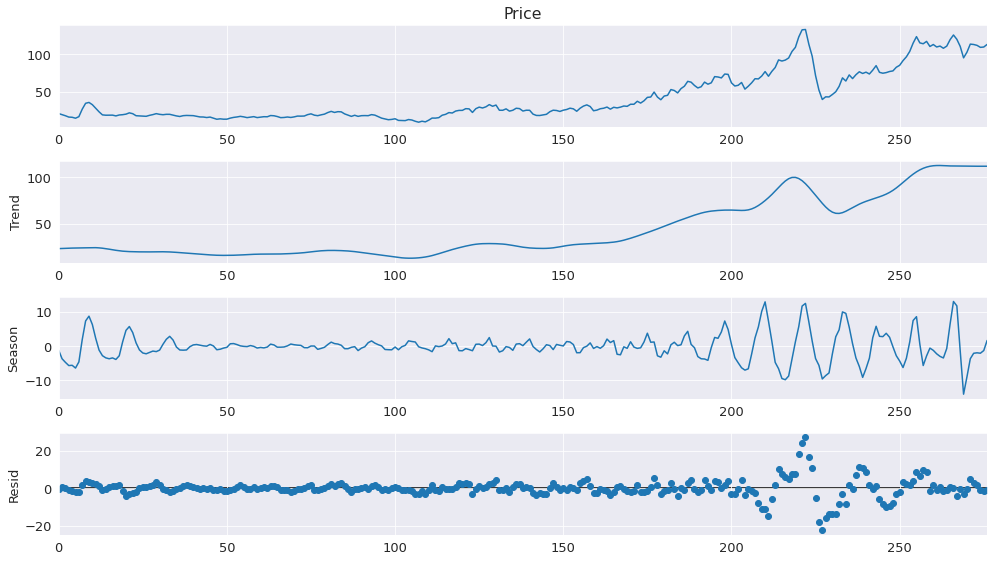

In [ ]:
res = stl.fit()
fig = res.plot()

- There is gradual increase in trend
- No clear pattern can be seen in Seasonality so our initial observation was correct
- residuals are also random

lets transform the data by differencing method to get rid of trend

In [ ]:
df_diff1 = difference(train, interval=1)

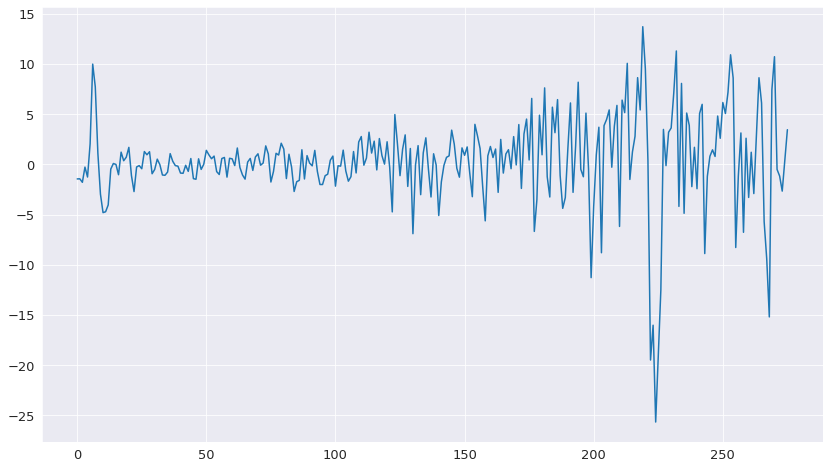

In [ ]:
plt.plot(df_diff1)

In [ ]:
# lets check wheather our data has now become stationary or not using ADF test
dicky_fuller_test(df_diff1)

ADF Statistic: -5.998613
p-value: 0.000000
Critical Values:
	1%: -3.455
	5%: -2.873
	10%: -2.573
Reject the null hypothesis (H0), the data is stationary.


-----------------------------------------------------------------------------
Since, the data is now stationary, we will plot ACF-PACF plots to get the neccessary parameters of ARIMA model


**ACF-PACF Plots**

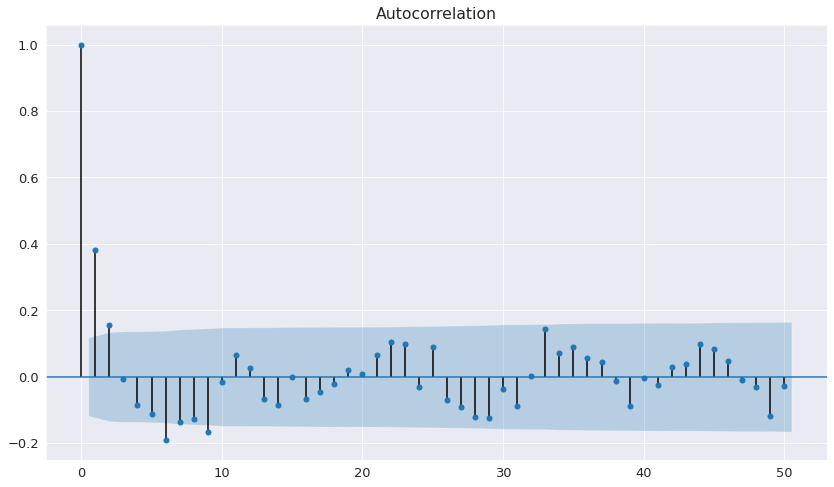

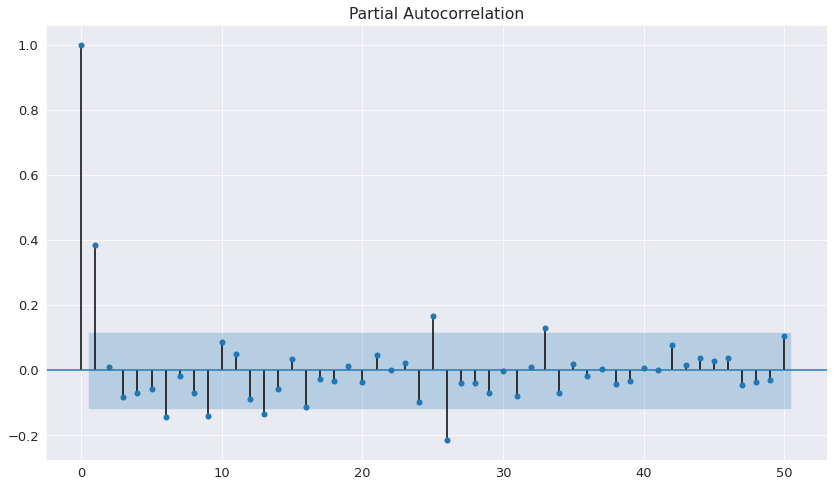

In [ ]:
#plotting acf and pacf

fig1 = sm.graphics.tsa.plot_acf(df_diff1,lags=50)
fig2 = sm.graphics.tsa.plot_pacf(df_diff1,lags=50)

**Observations**
- From PACF plot we can say that p=1 as after lag 1 most for the lags are not significant
- From ACF plot q=2 or 1 as second lag is very close to significance threshold region 
- d value would be 1 as we have differenced once to make the series stationary
- In SARIMA model P,D,Q,s =0 as no seasonality present in the series
- Also, we see Geometric decay in ACF plot and High degree of autocorrelation between adjacent (lag = 1) in PACF plot , so we can say that it is AR(p) process and MA(q) process is not required

In [ ]:
# Applying ARIMA
my_model = sm.tsa.arima.ARIMA(train, order=(1,1,0)) # q=0 as only AR model is required 
my_model_res = my_model.fit()
print(my_model_res.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  277
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -786.494
Date:                Sun, 20 Nov 2022   AIC                           1576.989
Time:                        08:48:05   BIC                           1584.230
Sample:                             0   HQIC                          1579.895
                                - 277                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3850      0.030     12.805      0.000       0.326       0.444
sigma2        17.4751      0.905     19.306      0.000      15.701      19.249
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [ ]:
pred_no=test.shape[0]
pred_no

119

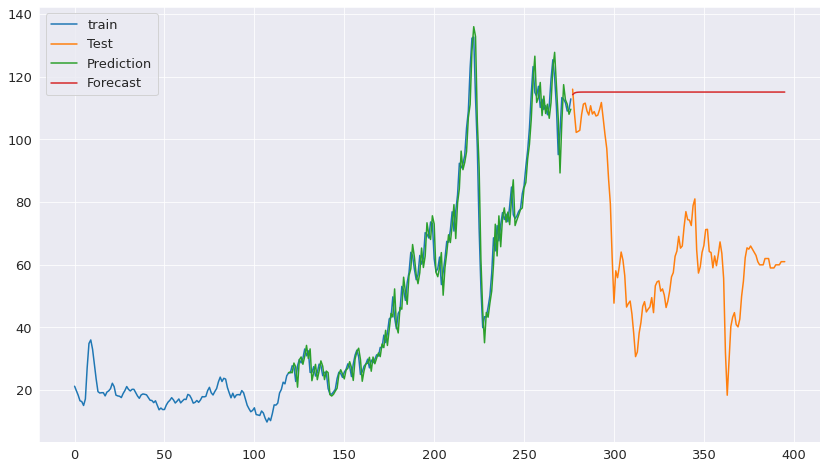

In [ ]:
#predicting and forecast on train and test data

tspredict= my_model_res.predict(pred_no)

tsforecast=my_model_res.forecast(pred_no)

plt.plot(train,label='train')
plt.plot(test,label='Test')
plt.plot(tspredict,label='Prediction')
plt.plot(tsforecast,label='Forecast')
plt.legend()

- The predictions are quite good.
- Forecast is just an upward trend because seasonality wasn’t taken into consideration.

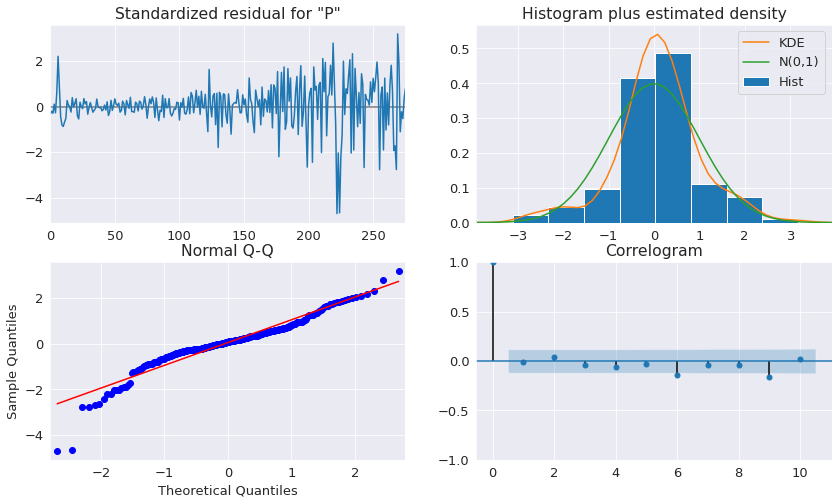

In [ ]:
pred = my_model_res.plot_diagnostics()

### Observations

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself and hence their mean is zero.

- The KDE plot of the residuals on the top right shows a kind of similar plot as a normal distribution.

- From the normal Q-Q plot, one can infer that we almost have a straight line, which suggests no systematic departure from normality. 



Evaluation metrics-rmse

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
test.shape

(119,)

In [ ]:
rmse = mean_squared_error(test, tsforecast, squared=False)
rmse

54.37039731974014

In [ ]:
tsforecast.describe()

count    119.000000
mean     115.118701
std        0.082555
min      114.294541
25%      115.130119
50%      115.130119
75%      115.130119
max      115.130119
Name: predicted_mean, dtype: float64

# **Auto-Arima**

In [ ]:
from pmdarima import auto_arima

In [ ]:
arima_model = auto_arima(train,start_p=0, d=1, start_q=0,max_p=5, max_d=5, max_q=5,
                        error_action="ignore",trace = True,
                         suppress_warnings=True,stepwise = True,
                         random_state=20,n_fits= 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1619.856, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1578.310, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1585.279, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1619.344, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1580.284, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1580.292, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1582.074, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1576.989, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1578.949, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1578.961, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1584.255, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1580.729, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.025 seconds


In [ ]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  277
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -786.494
Date:                Sun, 20 Nov 2022   AIC                           1576.989
Time:                        08:48:08   BIC                           1584.230
Sample:                             0   HQIC                          1579.895
                                - 277                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3850      0.030     12.805      0.000       0.326       0.444
sigma2        17.4751      0.905     19.306      0.000      15.701      19.249
Ljung-Box (L1) (Q):                   0.01   Jarque-

## Forecasting using Auto ARIMA

In [ ]:
forecast =pd.DataFrame(arima_model.predict(n_periods=119),columns=['forecast'],index=test.index)
forecast

,forecast
277,114.294541
278,114.808390
279,115.006241
280,115.082422
281,115.111754
...,...
391,115.130119
392,115.130119
393,115.130119
394,115.130119


In [ ]:
forecast_df =pd.DataFrame(arima_model.predict(n_periods=12),columns=['forecast'],index=test.index)
forecast_df=pd.concat([forecast, test],axis=1)
forecast_df

,forecast,Price
277,114.294541,116.051
278,114.808390,108.474
279,115.006241,102.248
280,115.082422,102.559
281,115.111754,102.920
...,...,...
391,115.130119,60.000
392,115.130119,60.000
393,115.130119,61.000
394,115.130119,61.000


In [ ]:
forecast_df.describe()

,forecast,Price
count,119.000000,119.000000
mean,115.118701,65.372210
std,0.082555,22.009528
min,114.294541,18.380000
25%,115.130119,50.958000
50%,115.130119,61.000000
75%,115.130119,71.275500
max,115.130119,116.051000


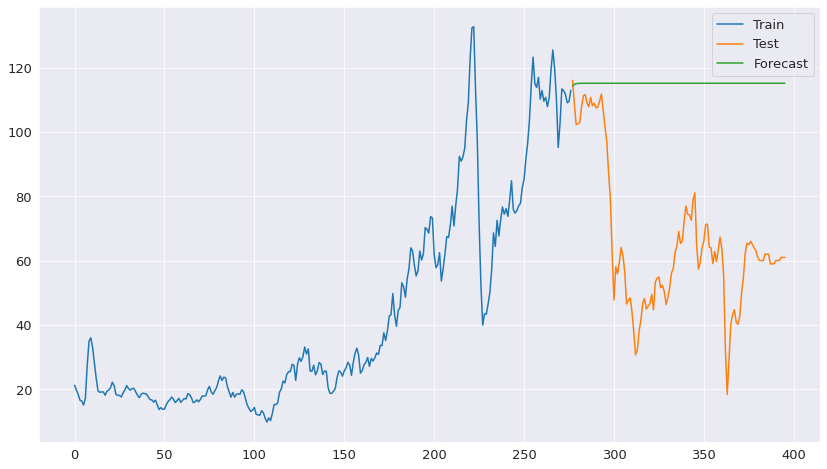

In [ ]:
#plotting the graph

plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(forecast,label='Forecast')
#plt.plot(tsforecast,label='Forecast')
plt.legend()

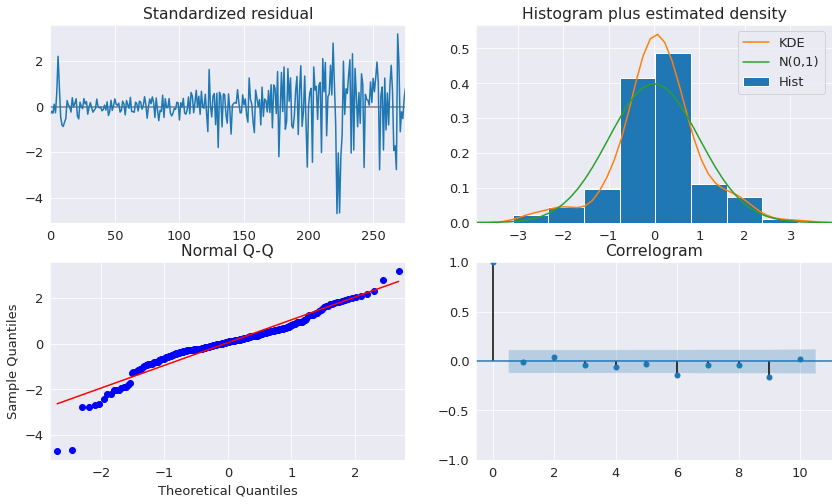

In [ ]:
#plotting diagnostics

d= arima_model.plot_diagnostics()

Since our ARIMA model parameters p,d,q=(1,1,0) are same as that AUTO_ARIMA parameters we have got the exact same results 

In [ ]:
rms = np.sqrt(mean_squared_error(test,forecast_df['forecast'])) # same as squared=False
print('Rmse value:',rms) 

Rmse value: 54.37039731974014


# **Holt-Winter**

In [ ]:
from statsmodels.tsa.holtwinters import Holt # since we only have trend in our data we will apply Holt's model

In [ ]:
model = Holt(train)
result = model.fit()
result.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  if self.nobs < 10 + 2 * (self.seasonal_periods // 2):


{'smoothing_level': 0.9999936199866225,
 'smoothing_trend': 1.3450809152291435e-07,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 20.918813343548706,
 'initial_trend': 0.3322669370473991,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
print(result.summary())

                              Holt Model Results                              
Dep. Variable:                  Price   No. Observations:                  277
Model:                           Holt   SSE                           5636.847
Optimized:                       True   AIC                            842.618
Trend:                       Additive   BIC                            857.114
Seasonal:                        None   AICC                           842.929
Seasonal Periods:                None   Date:                 Sun, 20 Nov 2022
Box-Cox:                        False   Time:                         08:48:09
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9999936                alpha                 True
smoothing_trend           1.3451e-07                

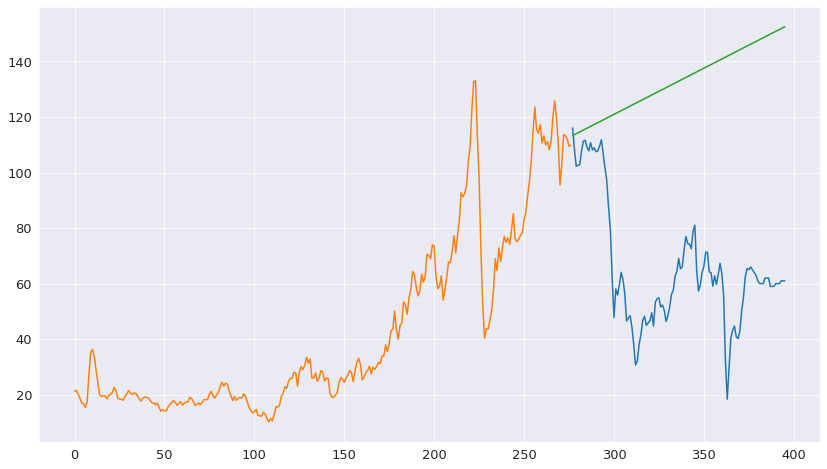

In [ ]:
plt.plot(test)
plt.plot(result.fittedvalues)
plt.plot(result.forecast(119))

In [ ]:
rmse = mean_squared_error(test, result.forecast(pred_no), squared=False)
rmse

73.64711527434652

- As rmse value of holt winters model is 73.64 which is greater than rmse value of AR(54.37) Model, therefore we can say that for this scenario AR model fits better 

In [ ]:
# lets also check manually 

In [ ]:
rolling = df.rolling(10) # moving average with window 10
type(rolling)

pandas.core.window.rolling.Rolling

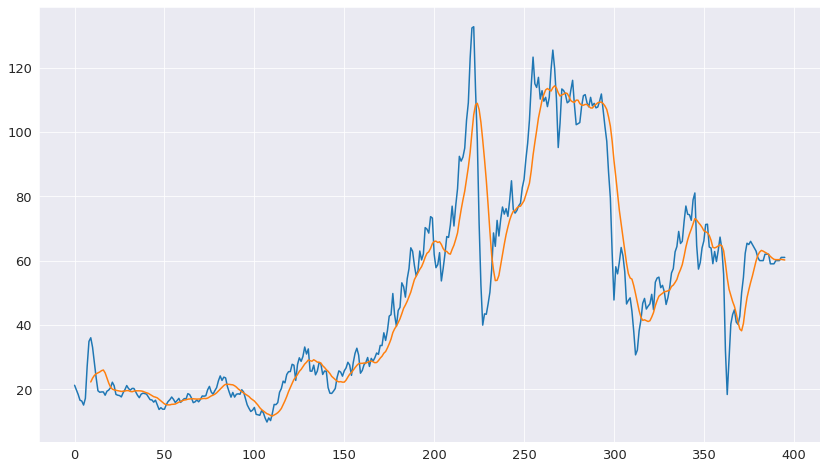

In [ ]:
mavg = rolling.mean()
plt.plot(df)
plt.plot(mavg)

In [ ]:
# Exponentially Weighted Moving Average or Exponential smoothing

In [ ]:
n=1/(2*12)
n

0.041666666666666664

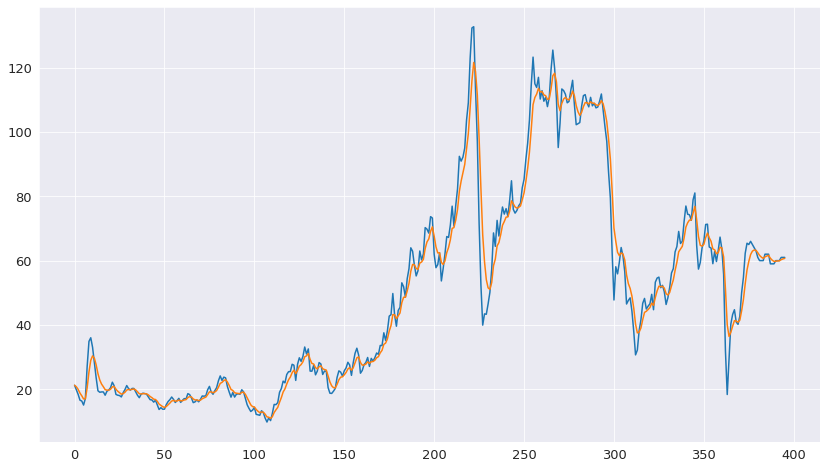

In [ ]:
# Try out the following with various values of 'alpha' and evaluate the results
ewma = df.ewm(alpha=0.34, adjust=False).mean() # as we increase alpha value our smoothing curve follows original curve # at 0.9 value it almost matches the original curve
                                              # as we decrease alpha value more smooth curve we get and less it follows original curve
plt.plot(df)
plt.plot(ewma)

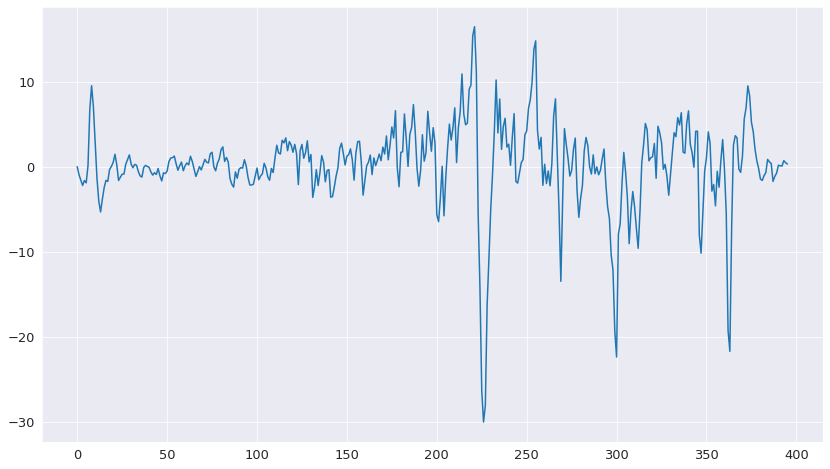

In [ ]:
plt.plot(df-ewma) # differencing transformation resulting to de-trended series

Lets apply Holt-Winter manually step by step

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [ ]:
ses = SimpleExpSmoothing(train) # moving average

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  if self.nobs < 10 + 2 * (self.seasonal_periods // 2):


In [ ]:
result = ses.fit(smoothing_level=0.1, optimized=False)

In [ ]:
print(result.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  Price   No. Observations:                  277
Model:             SimpleExpSmoothing   SSE                          34593.091
Optimized:                      False   AIC                           1341.188
Trend:                           None   BIC                           1348.436
Seasonal:                        None   AICC                          1341.335
Seasonal Periods:                None   Date:                 Sun, 20 Nov 2022
Box-Cox:                        False   Time:                         08:48:11
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1000000                alpha                False
initial_level              21.251000                

In [ ]:
mypred = result.predict(start=1, end=400)

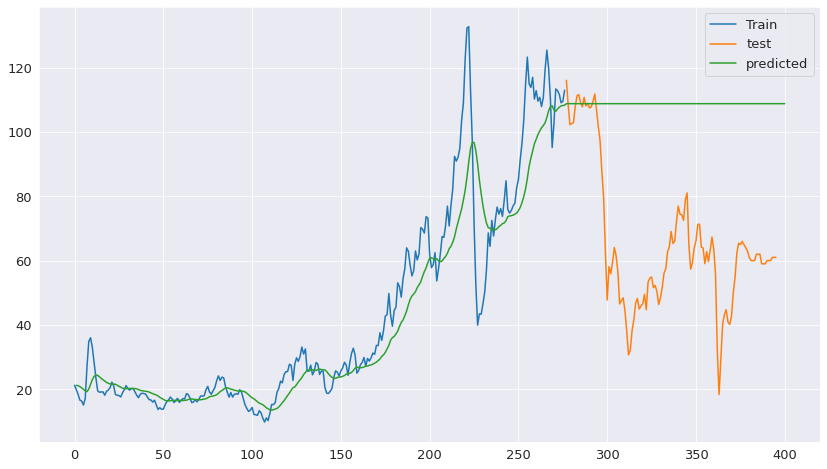

In [ ]:
plt.plot(train, label='Train')
plt.plot(test, label='test')
plt.plot(mypred, label='predicted')
plt.legend()

In [ ]:
result.params

{'smoothing_level': 0.1,
 'smoothing_trend': None,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': 21.251,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

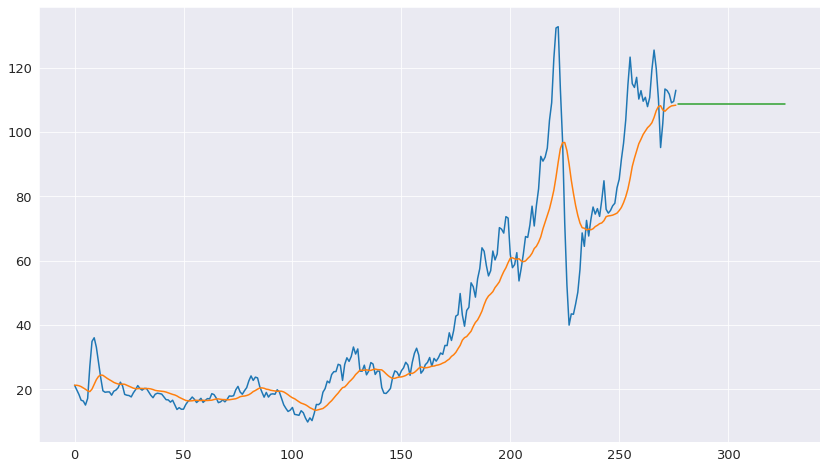

In [ ]:
plt.plot(train)
plt.plot(result.fittedvalues)
plt.plot(result.forecast(50))

exp smoothing


In [ ]:
# Holt's linear trend values

In [ ]:
from statsmodels.tsa.holtwinters import Holt

In [ ]:
model = Holt(train, exponential=False)
result = model.fit()
result.params

{'smoothing_level': 0.9999936199866225,
 'smoothing_trend': 1.3450809152291435e-07,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 20.918813343548706,
 'initial_trend': 0.3322669370473991,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
print(result.summary())

                              Holt Model Results                              
Dep. Variable:                  Price   No. Observations:                  277
Model:                           Holt   SSE                           5636.847
Optimized:                       True   AIC                            842.618
Trend:                       Additive   BIC                            857.114
Seasonal:                        None   AICC                           842.929
Seasonal Periods:                None   Date:                 Sun, 20 Nov 2022
Box-Cox:                        False   Time:                         08:48:12
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9999936                alpha                 True
smoothing_trend           1.3451e-07                

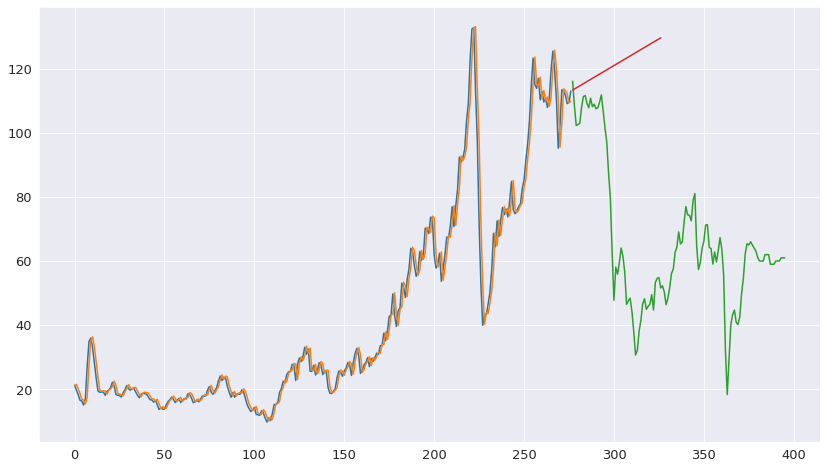

In [ ]:
plt.plot(train)
plt.plot(result.fittedvalues)
plt.plot(test)
plt.plot(result.forecast(50))

We can say that its very challenging to predict crude oil prices. The fluctuations in the prices of crude oil are random and are highly dependent on demand and suppy scenerio, which is why we are getting incorrect prediction values  

If we keep the test size to be 20% we get better result in Holt's model as compared to ARIMA as holt model predicts the values as increasing trend and not a flat line 